In [55]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import  ncx2
import pandas as pd

In [56]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1
        self.bxt_x = lambda x: 0
        self.bxt_xx = lambda x: 0
        self.sigmaxt_x = lambda x: 0
        self.sigmaxt_xx = lambda x: 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        result = np.zeros(self.Nx)
        for k in range(0, self.Nx):
            result[k] = x0[k] + np.random.normal(0, 1) * np.sqrt(t - t0)
        return result

    def PathGenerator(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = self.SampleFromDensity(x_data[i - 1], t_data[i], t_data[i - 1])
        return t_data, x_data

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + dwt[i - 1]
        return t_data, x_data

    def EulerSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data

    def Milstein1Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + \
                        1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * (dwt[i - 1]**2 - dt)
        return t_data, x_data

    def Milstein2Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1]) - 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])) * dt +\
                        self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) + 1/2 * self.bxt_x(x_data[i - 1]) * self.sigmaxt(x_data[i - 1]) +\
                        1/4 * self.sigmaxt(x_data[i - 1])**2 * self.sigmaxt_xx(x_data[i - 1])) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.bxt_x(x_data[i - 1]) + 1/4 * self.bxt_xx(x_data[i - 1]) * self.sigmaxt(x_data[i - 1])**2) * dt**2
        return t_data, x_data

    def PredictorCorrectorSolution(self, dwt, eta = 1/2, alpha = 1/2):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            yw = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
            bwim1 = self.bxt(x_data[i - 1]) - eta * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])
            bwi = self.bxt(yw) - eta * self.sigmaxt(yw) * self.sigmaxt_x(yw)
            x_data[i] = x_data[i - 1] + alpha * bwi * dt + (1 - alpha) * bwim1 * dt +\
                        eta * self.sigmaxt(yw) * dwt[i - 1] + (1 - eta) * self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data


class OUprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]
        self.bxt_x = lambda x: -self.params[0]

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu
            v = sigma**2 / (2 * theta)
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu + (x0[j] - mu) * np.exp(-theta * (t - t0))
            v = sigma**2 / (2 * theta) * (1 - np.exp(-2 * theta * (t - t0)))
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = mu + (x_data[0] - mu) * np.exp(-theta * t_data)
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += sigma * np.exp(theta * t_data[i - 1]) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta * t_data[i])
        return t_data, x_data


class CIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))
        self.bxt_x = lambda x: - self.params[1]
        self.sigmaxt_x = lambda x: self.params[2] * 1 / (2 * np.sqrt(np.maximum(x, 0)))
        self.sigmaxt_xx = lambda x: -self.params[2] * 1 / (4 * np.maximum(x, 0)**(1/4))

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2)
            u = 0
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2 * (1 - np.exp(-k * (t - t0))))
            u = c * x0[j] * np.exp(-k * (t - t0))
            #v = c * x
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t_data) + theta1/theta2
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += theta3 * np.exp(theta2 * t_data[i - 1]) * np.sqrt(np.maximum(x_data[i - 1], 0)) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta2 * t_data[i])
        return t_data, x_data


class BSMprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2] or [r, sigma]
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x
        self.bxt_x = lambda x: self.params[0]
        self.sigmaxt_x = lambda x: self.params[1]

    def DefaultInitState(self):
        return np.ones(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        r = self.params[0]
        sigma = self.params[1]

        result = np.zeros(self.Nx)

        m = (r - 1/2 * sigma**2) * (t - t0)
        v = sigma**2 * (t - t0)

        for j in range(0, self.Nx):
            result[j] = x0[j] * np.random.lognormal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        r = self.params[0]
        sigma = self.params[1]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] * np.exp((r - sigma**2 / 2) * dt + sigma * dwt[i - 1])
        return t_data, x_data

Task 1. Suppose we have a   Brownian motion  defined by
 $$
 dX_t = \theta_1 X_tdt + \theta_2X_tdW_t, \quad X_0 = 1, \text{ with } (\theta_1, \theta_2) = (2, 0.5).
 $$
Compare approximations
*   the Euler approximation algorithm;
*   the 1st Milstein scheme;
*   the 2nd Milstein scheme;
*   the predictor-corrector method  (set default $\alpha = \eta = 1/2$);
*   KPS method

with the exact solution on $[0,1]$, levels of discretization $N=1024$.

In [57]:
T = 1
Nx = 1
Nt = 1024

x0 = 1
init_state = x0 * np.ones(Nx)

#theta = 2
#mu = 10
#sigma = 3.5
#params = [theta, mu, sigma]

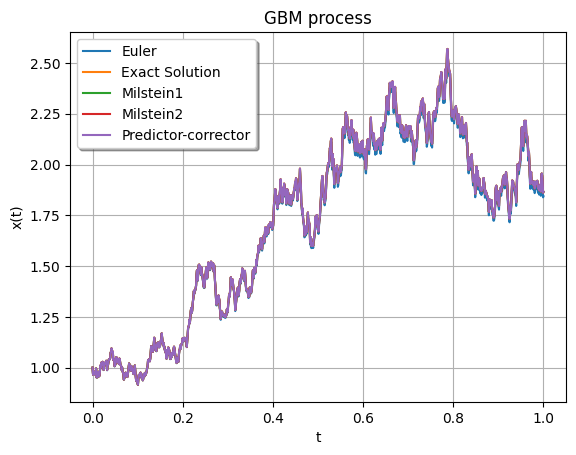

In [58]:
theta1 = 1
theta2 = 1/2
params = [theta1, theta2]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)


BSMp = BSMprocess(params, T, Nx, Nt, init_state)
t_data, x_data = BSMp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = BSMp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = BSMp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = BSMp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = BSMp.PredictorCorrectorSolution(dwt, 1/2, 1/2)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("GBM process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Compare the different approximations and the exact solution Brownian motion
for different levels of discretization
$$
N=\{2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768\}
$$
being the number of subintervals of $[0,1]$.
As the result provide the table with maximum absolute difference.


In [59]:
discretizations = [2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768]
errors = []

for Nt in discretizations:
    dwt = np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(T / Nt)
    BSMp = BSMprocess(params, T, Nx, Nt, init_state)

    _, exact_solution = BSMp.ExactSolution(dwt)
    _, euler_solution = BSMp.EulerSolution(dwt)
    
    # Compute the maximum absolute error for Euler
    max_diff = np.max(np.abs(euler_solution - exact_solution))
    errors.append(max_diff)

# Display the results in a table
for N, error in zip(discretizations, errors):
    print(f"N={N}: Max Error = {error}")


N=2: Max Error = 0.12572650887214865
N=4: Max Error = 0.5481807539462658
N=8: Max Error = 0.2019084059682843
N=128: Max Error = 0.05923677447549425
N=256: Max Error = 0.02709763930287279
N=512: Max Error = 0.01743015839326434
N=1024: Max Error = 0.006495061995407836
N=8192: Max Error = 0.0016974567335712454
N=16384: Max Error = 0.0036670978281518885
N=32768: Max Error = 0.0034872625176465277


Task. Conduct a study of the influence of the choice of values $\alpha$ and $\eta$ ​​on the accuracy of the  solution and plot a 3D graph where the x-axis is $α$'s values, y-axis is $\eta$'s values, and z-axis are maximum absolute difference between the exact solution and the predictor-corrector approximation.



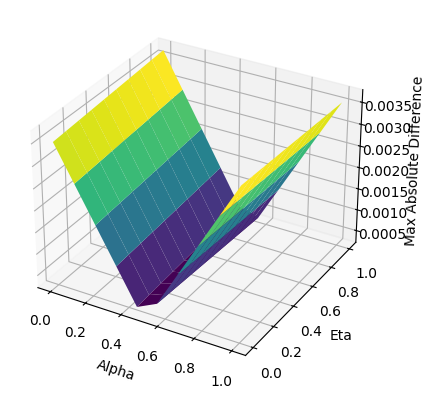

In [60]:
from mpl_toolkits.mplot3d import Axes3D

alphas = np.linspace(0, 1, 10)
etas = np.linspace(0, 1, 10)
differences = np.zeros((len(alphas), len(etas)))

for i, alpha in enumerate(alphas):
    for j, eta in enumerate(etas):
        _, approx = BSMp.PredictorCorrectorSolution(dwt, eta, alpha)
        _, exact = BSMp.ExactSolution(dwt)
        differences[i, j] = np.max(np.abs(approx - exact))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
alpha_grid, eta_grid = np.meshgrid(alphas, etas)
ax.plot_surface(alpha_grid, eta_grid, differences, cmap='viridis')
ax.set_xlabel("Alpha")
ax.set_ylabel("Eta")
ax.set_zlabel("Max Absolute Difference")
plt.show()


Task 2.  Repeat the Task 1 for the Cox-Ingersoll-Ross process
$$
dX_t = (\theta_1 - \theta_2X_t)dt + \theta_3 \sqrt{ X_t}dW_t, X_0 = 10, (\theta_1, \theta_2, \theta_3) = (6, 3, 2).
$$

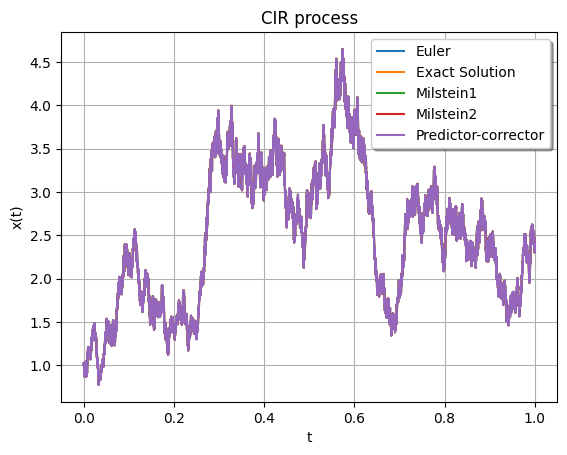

In [61]:
theta1 = 6
theta2 = 3
theta3 = 2
params = [theta1, theta2, theta3]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)

CIRp = CIRprocess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = CIRp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = CIRp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = CIRp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = CIRp.PredictorCorrectorSolution(dwt, 0.4, 0.6)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("CIR process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Compare the speed of convergence for four schemes from Task 1 with extract solution on the graph where the x-axis is  log(N) values, y-axis is  X(t). See example in the study aid.

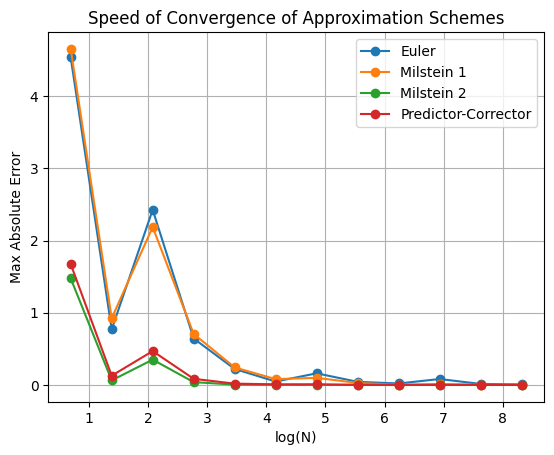

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the Brownian motion process
T = 1
Nx = 1
theta1, theta2 = 2, 0.5
params = [theta1, theta2]
x0 = 1
init_state = x0 * np.ones(Nx)

# Define the discretization levels for comparison
discretizations = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
errors_euler = []
errors_milstein1 = []
errors_milstein2 = []
errors_predictor_corrector = []

# Iterate over each discretization level
for Nt in discretizations:
    # Generate the Wiener increments for this level of discretization
    dwt = np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(T / Nt)

    # Instantiate the process for the current discretization
    BSMp = BSMprocess(params, T, Nx, Nt, init_state)

    # Exact solution
    _, exact_solution = BSMp.ExactSolution(dwt)

    # Euler method
    _, euler_solution = BSMp.EulerSolution(dwt)
    errors_euler.append(np.max(np.abs(euler_solution - exact_solution)))

    # Milstein 1 method
    _, milstein1_solution = BSMp.Milstein1Solution(dwt)
    errors_milstein1.append(np.max(np.abs(milstein1_solution - exact_solution)))

    # Milstein 2 method
    _, milstein2_solution = BSMp.Milstein2Solution(dwt)
    errors_milstein2.append(np.max(np.abs(milstein2_solution - exact_solution)))

    # Predictor-Corrector method
    _, predictor_corrector_solution = BSMp.PredictorCorrectorSolution(dwt, 0.5, 0.5)
    errors_predictor_corrector.append(np.max(np.abs(predictor_corrector_solution - exact_solution)))

# Convert discretizations to log scale for plotting
log_discretizations = np.log(discretizations)

# Plotting the errors for each scheme
plt.plot(log_discretizations, errors_euler, label='Euler', marker='o')
plt.plot(log_discretizations, errors_milstein1, label='Milstein 1', marker='o')
plt.plot(log_discretizations, errors_milstein2, label='Milstein 2', marker='o')
plt.plot(log_discretizations, errors_predictor_corrector, label='Predictor-Corrector', marker='o')

# Formatting the plot
plt.xlabel("log(N)")
plt.ylabel("Max Absolute Error")
plt.title("Speed of Convergence of Approximation Schemes")
plt.legend(loc='best')
plt.grid(True)
plt.show()

Task 3. Generate 100 paths using conditional distribution of
* Ornstein-Uhlenbeck process $θ = (1, 1, 0.5)$,
* Geometric Brownian motion process $θ = (0.3, 0.1)$,
* Cox-Ingersoll-Ross process $θ = (0.4, 0.3, 0.2)$

with $X_0=0.5$.
Plot the random path for each process.

In [63]:
Nx = 100
Nt = 300
T = 1

params_OU = [1, 1, 0.5]
params_BSM = [0.3, 0.1]
params_CIR = [0.4, 0.3, 0.2]

init_state = 0.5 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)
BSMp = BSMprocess(params_BSM, T, Nx, Nt, init_state)
CIRp = CIRprocess(params_CIR, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.PathGenerator()
t_data, x_data_BSM = BSMp.PathGenerator()
t_data, x_data_CIR = CIRp.PathGenerator()

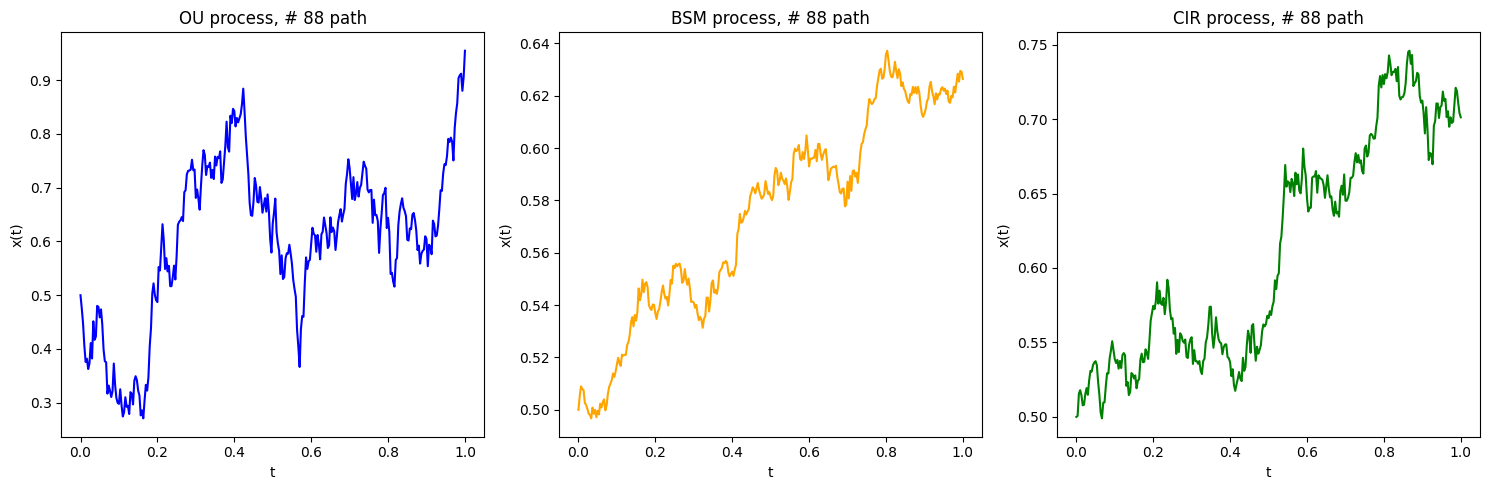

In [64]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

n = np.random.randint(0, Nx)

axs[0].plot(t_data, x_data_OU[:,n], color='blue')
axs[0].set_title(f'OU process, # {n} path')
axs[0].set_xlabel('t')
axs[0].set_ylabel('x(t)')

axs[1].plot(t_data, x_data_BSM[:,n], color='orange')
axs[1].set_title(f'BSM process, # {n} path')
axs[1].set_xlabel('t')
axs[1].set_ylabel('x(t)')

axs[2].plot(t_data, x_data_CIR[:,n], color='green')
axs[2].set_title(f'CIR process, # {n} path')
axs[2].set_xlabel('t')
axs[2].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

Task. Using the class template from Task 1, create class and design the path generator for one from the following processes:

1.   Modified CIR model;
2.   Chan-Karolyi-Longstaff-Sanders family of models;
1.   Nonlinear mean reversion Ait-Sahalia model;
2.   Jacobi diffusion process;
1.   Ahn and Gao (inverse of Feller’s square root) model;
2.   Radial Ornstein-Uhlenbeck process.

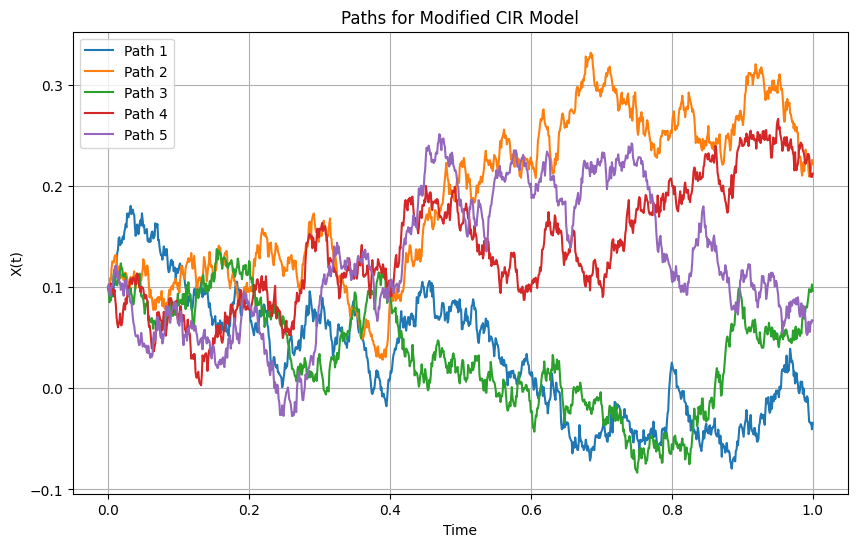

In [65]:
import numpy as np
from matplotlib import pyplot as plt

class ModifiedCIRProcess:
    def __init__(self, params, T, Nx, Nt, init_state=None):
        """
        Initialize the Modified CIR process with given parameters.
        
        Parameters:
            params (list): Model parameters [theta1, theta2]
            T (float): Total time duration
            Nx (int): Number of trajectories to generate
            Nt (int): Number of time discretization steps
            init_state (float or None): Initial state, defaults to zero if None
        """
        self.theta1 = params[0]  # Drift coefficient
        self.theta2 = params[1]  # Diffusion coefficient
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.init_state = init_state if init_state is not None else self.DefaultInitState()

    def DefaultInitState(self):
        """Set the default initial state for each trajectory."""
        return np.zeros(self.Nx)

    def drift(self, x):
        """Calculate the drift component of the Modified CIR model."""
        return -self.theta1 * x

    def diffusion(self, x):
        """Calculate the diffusion component of the Modified CIR model."""
        return self.theta2 * np.sqrt(1 + x**2)

    def PathGenerator(self):
        """Generate paths using the Euler-Maruyama method."""
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))
        x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            dWt = np.random.normal(0, 1, self.Nx) * np.sqrt(dt)
            x_data[i] = x_data[i - 1] + self.drift(x_data[i - 1]) * dt + self.diffusion(x_data[i - 1]) * dWt

        return t_data, x_data

# Example parameters
T = 1
Nx = 5  # Number of paths
Nt = 1000  # Number of discretization steps
theta1 = 0.5
theta2 = 0.2
params = [theta1, theta2]

# Instantiate and generate paths
modified_cir_process = ModifiedCIRProcess(params, T, Nx, Nt, init_state=np.ones(Nx) * 0.1)
t_data, x_data = modified_cir_process.PathGenerator()

# Plot the paths
plt.figure(figsize=(10, 6))
for i in range(Nx):
    plt.plot(t_data, x_data[:, i], label=f'Path {i+1}')
plt.title("Paths for Modified CIR Model")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.legend()
plt.grid(True)
plt.show()

Task 4. For the processes from previous task plot
* cumulative distribution (cdf),
* density function (pdf),      
* calculate the 90\%-quantile.

In [66]:
def ecdf(data):
    """Compute the empirical cumulative distribution function (CDF) for a data sample."""
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

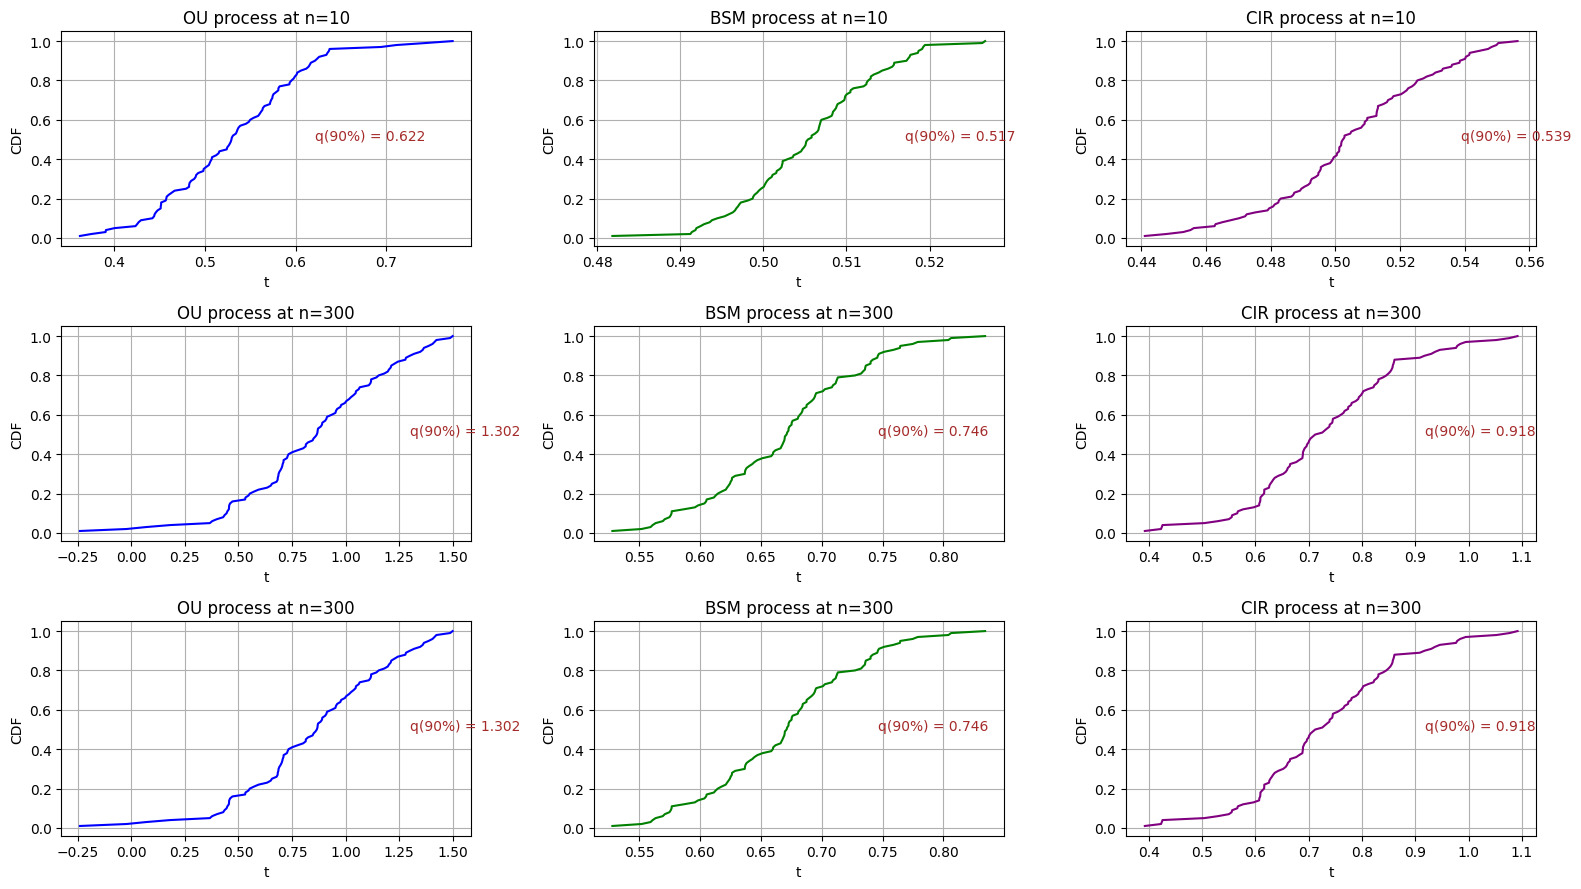

In [67]:
# Plot empirical CDFs and 90% quantiles for OU, BSM, and CIR processes
fig, axs = plt.subplots(3, 3, figsize=(16, 9))

# Define sample indices
n_values = [10, Nt // 2, Nt - 1]

for row, n in enumerate(n_values):
    # Ensure index n is within the bounds of the data arrays
    n = min(n, len(x_data_OU) - 1)
    
    # OU process
    axs[row][0].plot(*ecdf(x_data_OU[n]), color='blue')
    axs[row][0].set_title(f'OU process at n={n}')
    val = round(np.quantile(x_data_OU[n], 0.9), 3)
    axs[row][0].text(val, 0.5, f"q(90%) = {val}", color='brown')
    
    # BSM process
    axs[row][1].plot(*ecdf(x_data_BSM[n]), color='green')
    axs[row][1].set_title(f'BSM process at n={n}')
    val = round(np.quantile(x_data_BSM[n], 0.9), 3)
    axs[row][1].text(val, 0.5, f"q(90%) = {val}", color='brown')
    
    # CIR process
    axs[row][2].plot(*ecdf(x_data_CIR[n]), color='purple')
    axs[row][2].set_title(f'CIR process at n={n}')
    val = round(np.quantile(x_data_CIR[n], 0.9), 3)
    axs[row][2].text(val, 0.5, f"q(90%) = {val}", color='brown')

# Common adjustments for all subplots
for k in range(3):
    for j in range(3):
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('CDF')
        axs[k][j].grid(True)

plt.tight_layout()
plt.show()

Task. Perform the Kolmogorov-Smirnov test for two samples and present your conclusions. Add vertical lines (90\%-quantile) into plots.
Resize the range on the X-axis so that all curves for one process have the same range.    

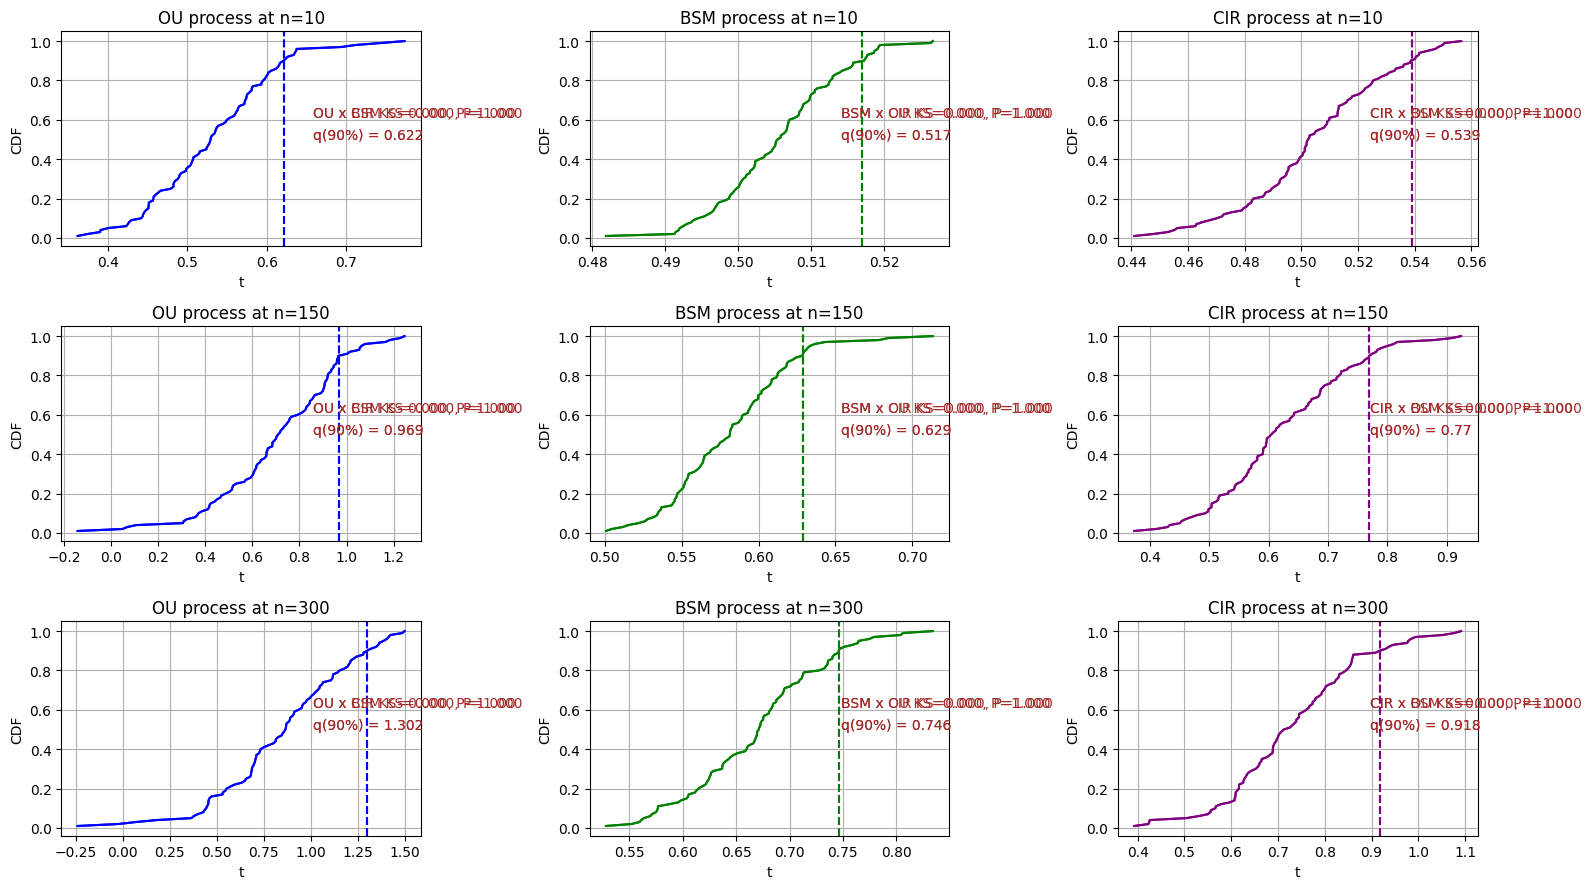

In [68]:
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

# Define the margin for text placement
margin = 0.7

# Plot empirical CDFs and 90% quantiles for OU, BSM, and CIR processes
fig, axs = plt.subplots(3, 3, figsize=(16, 9))

# Define sample indices safely based on data sizes
n_values = [10, min(len(x_data_OU) // 2, len(x_data_BSM) // 2, len(x_data_CIR) // 2),
            min(len(x_data_OU) - 1, len(x_data_BSM) - 1, len(x_data_CIR) - 1)]

# Helper function to plot and perform KS test
def plot_ecdf_with_ks(ax, x_data1, x_data2, n, color, title, label1, label2):
    # Ensure index n is within bounds
    n = min(n, len(x_data1) - 1)
    ax.plot(*ecdf(x_data1[n]), color=color)
    ax.set_title(f'{title} process at n={n}')
    
    # 90% quantile
    val = round(np.quantile(x_data1[n], 0.9), 3)
    ax.text(margin, 0.5, f"q(90%) = {val}", color='brown', transform=ax.transAxes)
    ax.axvline(x=val, color=color, linestyle='--', label=f'90%-Quantile {title}')
    
    # KS test between the distributions
    ks_stat, p_value = ks_2samp(ecdf(x_data1[n])[-1], ecdf(x_data2[n])[-1])
    ax.text(margin, 0.6, f"{label1} x {label2} KS={ks_stat:.3f}, P={p_value:.3f}", color='brown', transform=ax.transAxes)

# Plot OU, BSM, and CIR processes for each selected index
for row, n in enumerate(n_values):
    # OU vs. BSM and CIR
    plot_ecdf_with_ks(axs[row][0], x_data_OU, x_data_BSM, n, 'blue', 'OU', 'OU', 'BSM')
    plot_ecdf_with_ks(axs[row][0], x_data_OU, x_data_CIR, n, 'blue', 'OU', 'OU', 'CIR')
    
    # BSM vs. OU and CIR
    plot_ecdf_with_ks(axs[row][1], x_data_BSM, x_data_OU, n, 'green', 'BSM', 'BSM', 'OU')
    plot_ecdf_with_ks(axs[row][1], x_data_BSM, x_data_CIR, n, 'green', 'BSM', 'BSM', 'CIR')
    
    # CIR vs. OU and BSM
    plot_ecdf_with_ks(axs[row][2], x_data_CIR, x_data_OU, n, 'purple', 'CIR', 'CIR', 'OU')
    plot_ecdf_with_ks(axs[row][2], x_data_CIR, x_data_BSM, n, 'purple', 'CIR', 'CIR', 'BSM')

# Common adjustments for all subplots
for k in range(0, 3):
    for j in range(0, 3):
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('CDF')
        axs[k][j].grid(True)

plt.tight_layout()
plt.show()

In [69]:
def plot_density_histograms(x_data_OU, x_data_BSM, x_data_CIR, Nt):
    fig, axs = plt.subplots(3, 3, figsize=(16, 9))
    colors = ['blue', 'green', 'purple']
    titles = ['OU process', 'BSM process', 'CIR process']
    x_data_list = [x_data_OU, x_data_BSM, x_data_CIR]

    # Ensure time indices are within valid range
    max_index = min(Nt - 1, len(x_data_OU) - 1)
    time_indices = [10, max_index // 2, max_index]

    # Iterate over rows and columns to plot histograms
    for row, n in enumerate(time_indices):
        for col, (x_data, color, title) in enumerate(zip(x_data_list, colors, titles)):
            axs[row][col].hist(x_data[n], color=color)
            axs[row][col].set_title(f'{title} at t = {n}')
            axs[row][col].set_ylim(0, 350)
            axs[row][col].set_xlabel('t')
            axs[row][col].set_ylabel('x(t)')

    plt.tight_layout()
    plt.show()

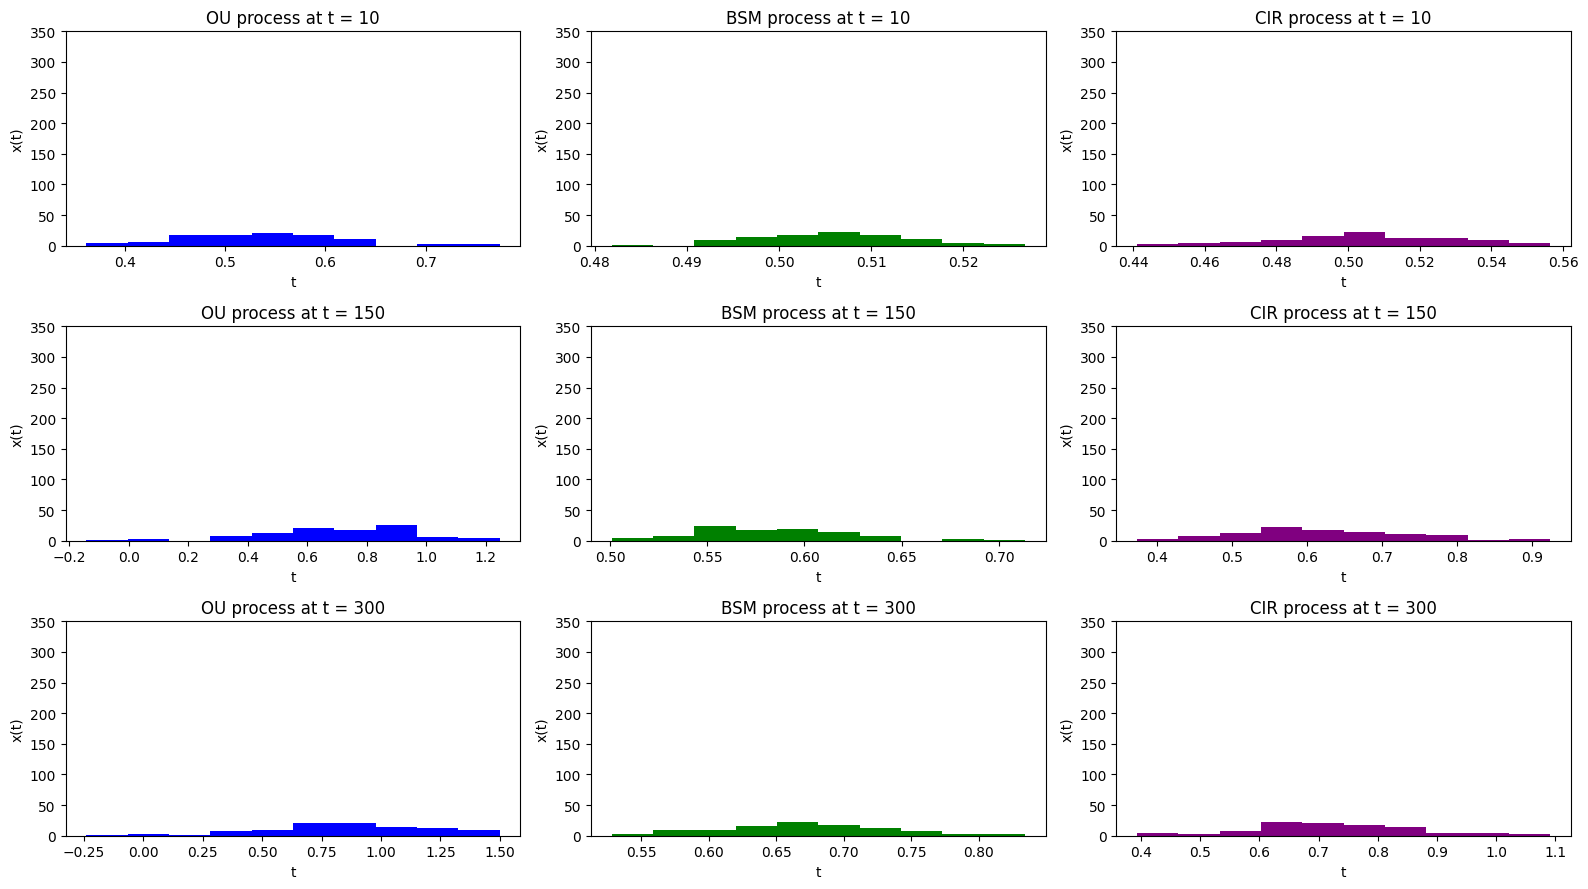

In [70]:
Nt = 500  # Number of time steps

# Call the function with the datasets
plot_density_histograms(x_data_OU, x_data_BSM, x_data_CIR, Nt)

Task. Perform a normality test on the histograms and present your conclusions.

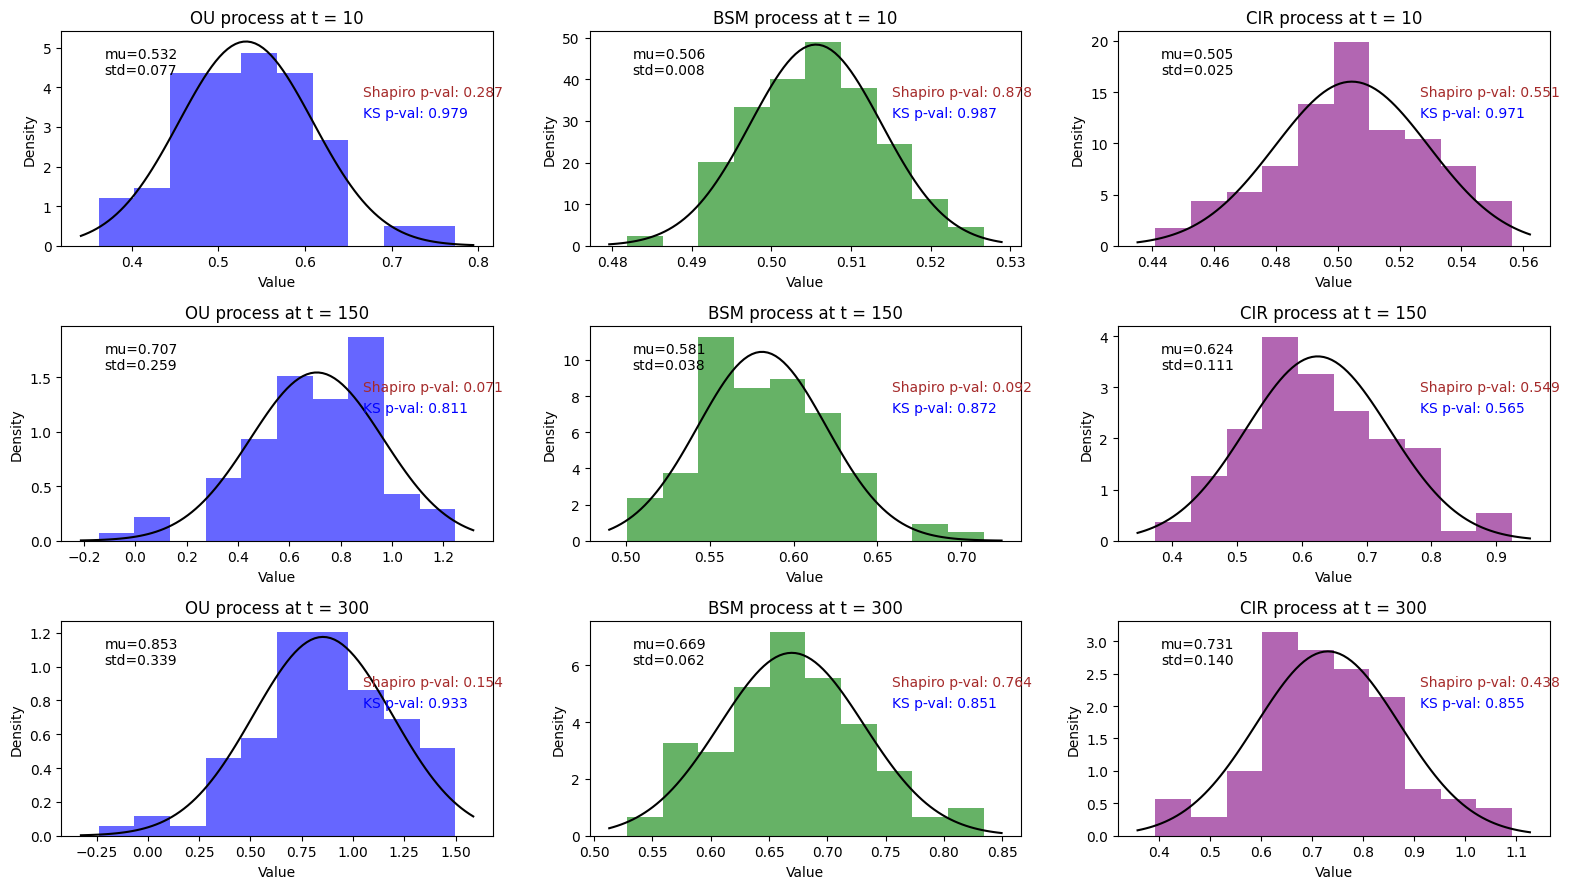

In [75]:
from scipy.stats import norm, shapiro, kstest
import matplotlib.pyplot as plt
import numpy as np

# Define the figure and axes
fig, axs = plt.subplots(3, 3, figsize=(16, 9))

# Ensure we do not exceed the length of the datasets
max_index = min(Nt - 1, len(x_data_OU) - 1, len(x_data_BSM) - 1, len(x_data_CIR) - 1)
ns = [10, max_index // 2, max_index]  # Adjust indices to valid range

# Define models, names, and colors for plotting
models = [x_data_OU, x_data_BSM, x_data_CIR]
names = ['OU', 'BSM', 'CIR']
colors = ['blue', 'green', 'purple']

# Loop over the time indices and models
for k, n in enumerate(ns):
    for j, (model, model_name, color) in enumerate(zip(models, names, colors)):
        # Plot histogram
        axs[k][j].hist(model[n], color=color, density=True, alpha=0.6)
        
        # Fit a normal distribution to the data
        mu, std = norm.fit(model[n])
        
        # Plot the fitted normal distribution
        xmin, xmax = axs[k][j].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        axs[k][j].plot(x, p, color='black')
        axs[k][j].text(0.1, 0.8, f'mu={mu:.3f}\nstd={std:.3f}', color='black', 
                       transform=axs[k][j].transAxes)

        # Shapiro-Wilk test for normality
        stat, p_value = shapiro(model[n])
        axs[k][j].text(0.7, 0.7, f'Shapiro p-val: {p_value:.3f}', color='brown', 
                       transform=axs[k][j].transAxes)
        
        # Kolmogorov-Smirnov test for normality
        ks_stat, ks_p_value = kstest(model[n], 'norm', args=(mu, std))
        axs[k][j].text(0.7, 0.6, f'KS p-val: {ks_p_value:.3f}', color='blue',  
                       transform=axs[k][j].transAxes)

        # Set titles and labels
        axs[k][j].set_title(f'{model_name} process at t = {n}')
        axs[k][j].set_xlabel('Value')
        axs[k][j].set_ylabel('Density')

plt.tight_layout()
plt.show()